In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

### 1. Loading data

First, loading the migraine dataset as a pandas dataframe and taking a look at it.

In [92]:
df = pd.read_csv('migraine_diary2.csv', encoding='latin-1', sep=';')
df['Intensity'] = df['Intensity'].fillna(0)
# If there was a headache, but the intensity was not specified, assuming the intensity was 3
df['Intensity'] = np.where((df['Headache'] == 'y') & (df['Intensity'] == 0), 3, df['Intensity']) 
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce', format='%d.%m.%Y')
df.drop_duplicates(subset='Date', inplace=True)
df.head()

,Date,Headache,Intensity
0,2020-09-26,y,7.0
1,2020-09-27,n,0.0
2,2020-09-28,n,0.0
3,2020-09-29,n,0.0
4,2020-09-30,n,0.0


The dataframe has three columns: **Date**, **Headache** (whether there was a headache or not, y/n), and the **Intensity** of the pain on a scale from 0 to 10. \
Taking a look at the distribution of days with and without headache.

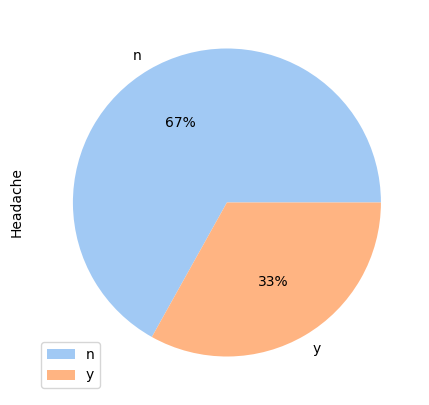

In [93]:
colors = sns.color_palette('pastel')
classes = pd.value_counts(df["Headache"])
classes.plot(kind='pie', figsize=(5,5), autopct='%0.f%%', legend=True, colors = colors)
plt.show() 

Then loading the period dataset in the same format and adding the period values to the created dataframe.

In [94]:
period_df = pd.read_csv('period_diary.csv', encoding='latin-1', sep=';')
period_df['date'] = pd.to_datetime(period_df['date'], errors = 'coerce', format='%d.%m.%Y')
period_df.drop_duplicates(subset='date', inplace=True)
df['Period'] = period_df['period']
df.head()

,Date,Headache,Intensity,Period
0,2020-09-26,y,7.0,y
1,2020-09-27,n,0.0,y
2,2020-09-28,n,0.0,y
3,2020-09-29,n,0.0,y
4,2020-09-30,n,0.0,y


In [95]:
df.Period.unique()

array(['y', nan, 'o'], dtype=object)

The **Period** column has three values: **y** for period, **o** for ovulation, and **nan** for no period. \
\
Taking a look at the dataset stats.

In [96]:
first_date = df.Date.iloc[0].date()
last_date = df.Date.iloc[-1].date()
delta = last_date - first_date
cycles = df.Period.value_counts()['o']

print('The journal starts on', first_date)
print('The journal ends on', last_date)
print('Total days:', delta.days)
print('Days without headache:', df.Headache.value_counts()['n'])
print('Days with headache:', df.Headache.value_counts()['y'])
print('Average headache intensity:', df[df.Intensity != 0].Intensity.mean())
print('Number of period cycles:', cycles)


The journal starts on 2020-09-26
The journal ends on 2022-04-24
Total days: 575
Days without headache: 384
Days with headache: 190
Average headache intensity: 4.110526315789474
Number of period cycles: 21


## 2. Preparing data

Breaking down the data into 30-day periods. This will make for a clearer visualization, and also allow to test out the data preparation functions on a smaller partition of data rather than on the whole dataset.

In [97]:
months = delta.days // 30
split_dfs = np.array_split(df, months)
print('Number of chunks:', len(split_dfs))

Number of chunks: 19


In [98]:
'''In order to achieve a smooth plotline, 
this function breaks down days into hours 
and interpolates the migraine Intensity values by hour,
returning a new dataframe that is indexed by hour,
as well as the new indices list
'''

def migraine_hourly(df):
    
    startDate = list(df['Date'])[0]
    endDate = list(df['Date'])[-1]
    index = pd.date_range(startDate, endDate)
    data = list(df['Intensity'])
    cols =['Headache Intensity']

    df = pd.DataFrame(data, index=index, columns = cols)
    index_hourly = pd.date_range(startDate, endDate, freq='1H')
    df_hourly = df.reindex(index=index_hourly).interpolate(method='pchip')
    return df_hourly, index_hourly

Taking a look at the first chunk of the new dataframe indexed by hour. 

In [99]:
df_hourly, index_hourly = migraine_hourly(split_dfs[0])
df_hourly

,Headache Intensity
2020-09-26 00:00:00,7.000000
2020-09-26 01:00:00,6.562753
2020-09-26 02:00:00,6.127025
2020-09-26 03:00:00,5.694336
2020-09-26 04:00:00,5.266204
...,...
2020-10-25 20:00:00,0.000000
2020-10-25 21:00:00,0.000000
2020-10-25 22:00:00,0.000000
2020-10-25 23:00:00,0.000000


If we take a look at the plotline, it looks smooth enough.

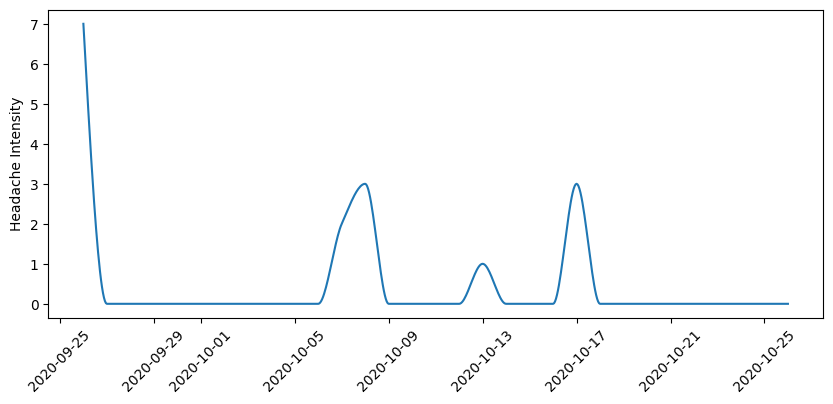

In [100]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df_hourly, x=df_hourly.index, y = df_hourly['Headache Intensity'], ax=ax)
ax.tick_params(axis='x', labelrotation = 45)

In [101]:
'''Function that extracts dates of periods and ovulations
from the dataframe'''

def period_lists(df):
    y_dates=[]
    o_dates=[]
    for index, row in df.iterrows():
        if row['Period']=='y':
            date=row['Date'].date()
            y_dates.append(date)
        if row['Period']=='o':
            date=row['Date'].date()
            o_dates.append(date)
    return y_dates, o_dates

In [102]:
y_dates, o_dates = period_lists(split_dfs[0])
print('The period dates are:', y_dates)
print('The ovulation dates are:', o_dates)

The period dates are: [datetime.date(2020, 9, 26), datetime.date(2020, 9, 27), datetime.date(2020, 9, 28), datetime.date(2020, 9, 29), datetime.date(2020, 9, 30), datetime.date(2020, 10, 26)]
The ovulation dates are: [datetime.date(2020, 10, 11)]


In [103]:
'''This function creates a list of values for the Period column
of the new hourly dataframe by checking if the dates 
are in the previously created lists of period and ovulation dates,
where y = period, n = no period, and o = ovulation,
and adding this list to the dataframe indexed by hours,
returning the dataframe'''

def period_hourly(df_hourly, y_dates, o_dates):
    period_list=[]
    for i in index_hourly:
        if i.date() in y_dates:
            period_list.append('y')
        elif i.date() in o_dates:
            period_list.append('o')
        else:
            period_list.append('n')
        
    df_hourly['Period']=period_list
    return df_hourly

In [104]:
df_hourly = period_hourly(df_hourly, y_dates, o_dates)
df_hourly.head()

,Headache Intensity,Period
2020-09-26 00:00:00,7.000000,y
2020-09-26 01:00:00,6.562753,y
2020-09-26 02:00:00,6.127025,y
2020-09-26 03:00:00,5.694336,y
2020-09-26 04:00:00,5.266204,y


In [83]:
def label_span(df_smooth_period):
    datespans=[]
    label0 = 'label'
    datespan = []
    labels=[]

    for index, row in df_smooth_period.iterrows():
        label = row['Period']    
        if label != label0:
            datespans.append(datespan)
            labels.append(label)
            datespan = []
            datespan.append(index)
            label0 = label
        elif label == label0:
            datespan.append(index)
    datespans.append(datespan)
    labels.append(label)

    del datespans[:1]
    del labels[-1:]
    
    return labels, datespans


In [84]:
labels, datespans = label_span(df_hourly)
print(labels, len(datespans))

['y', 'n', 'o', 'n'] 4


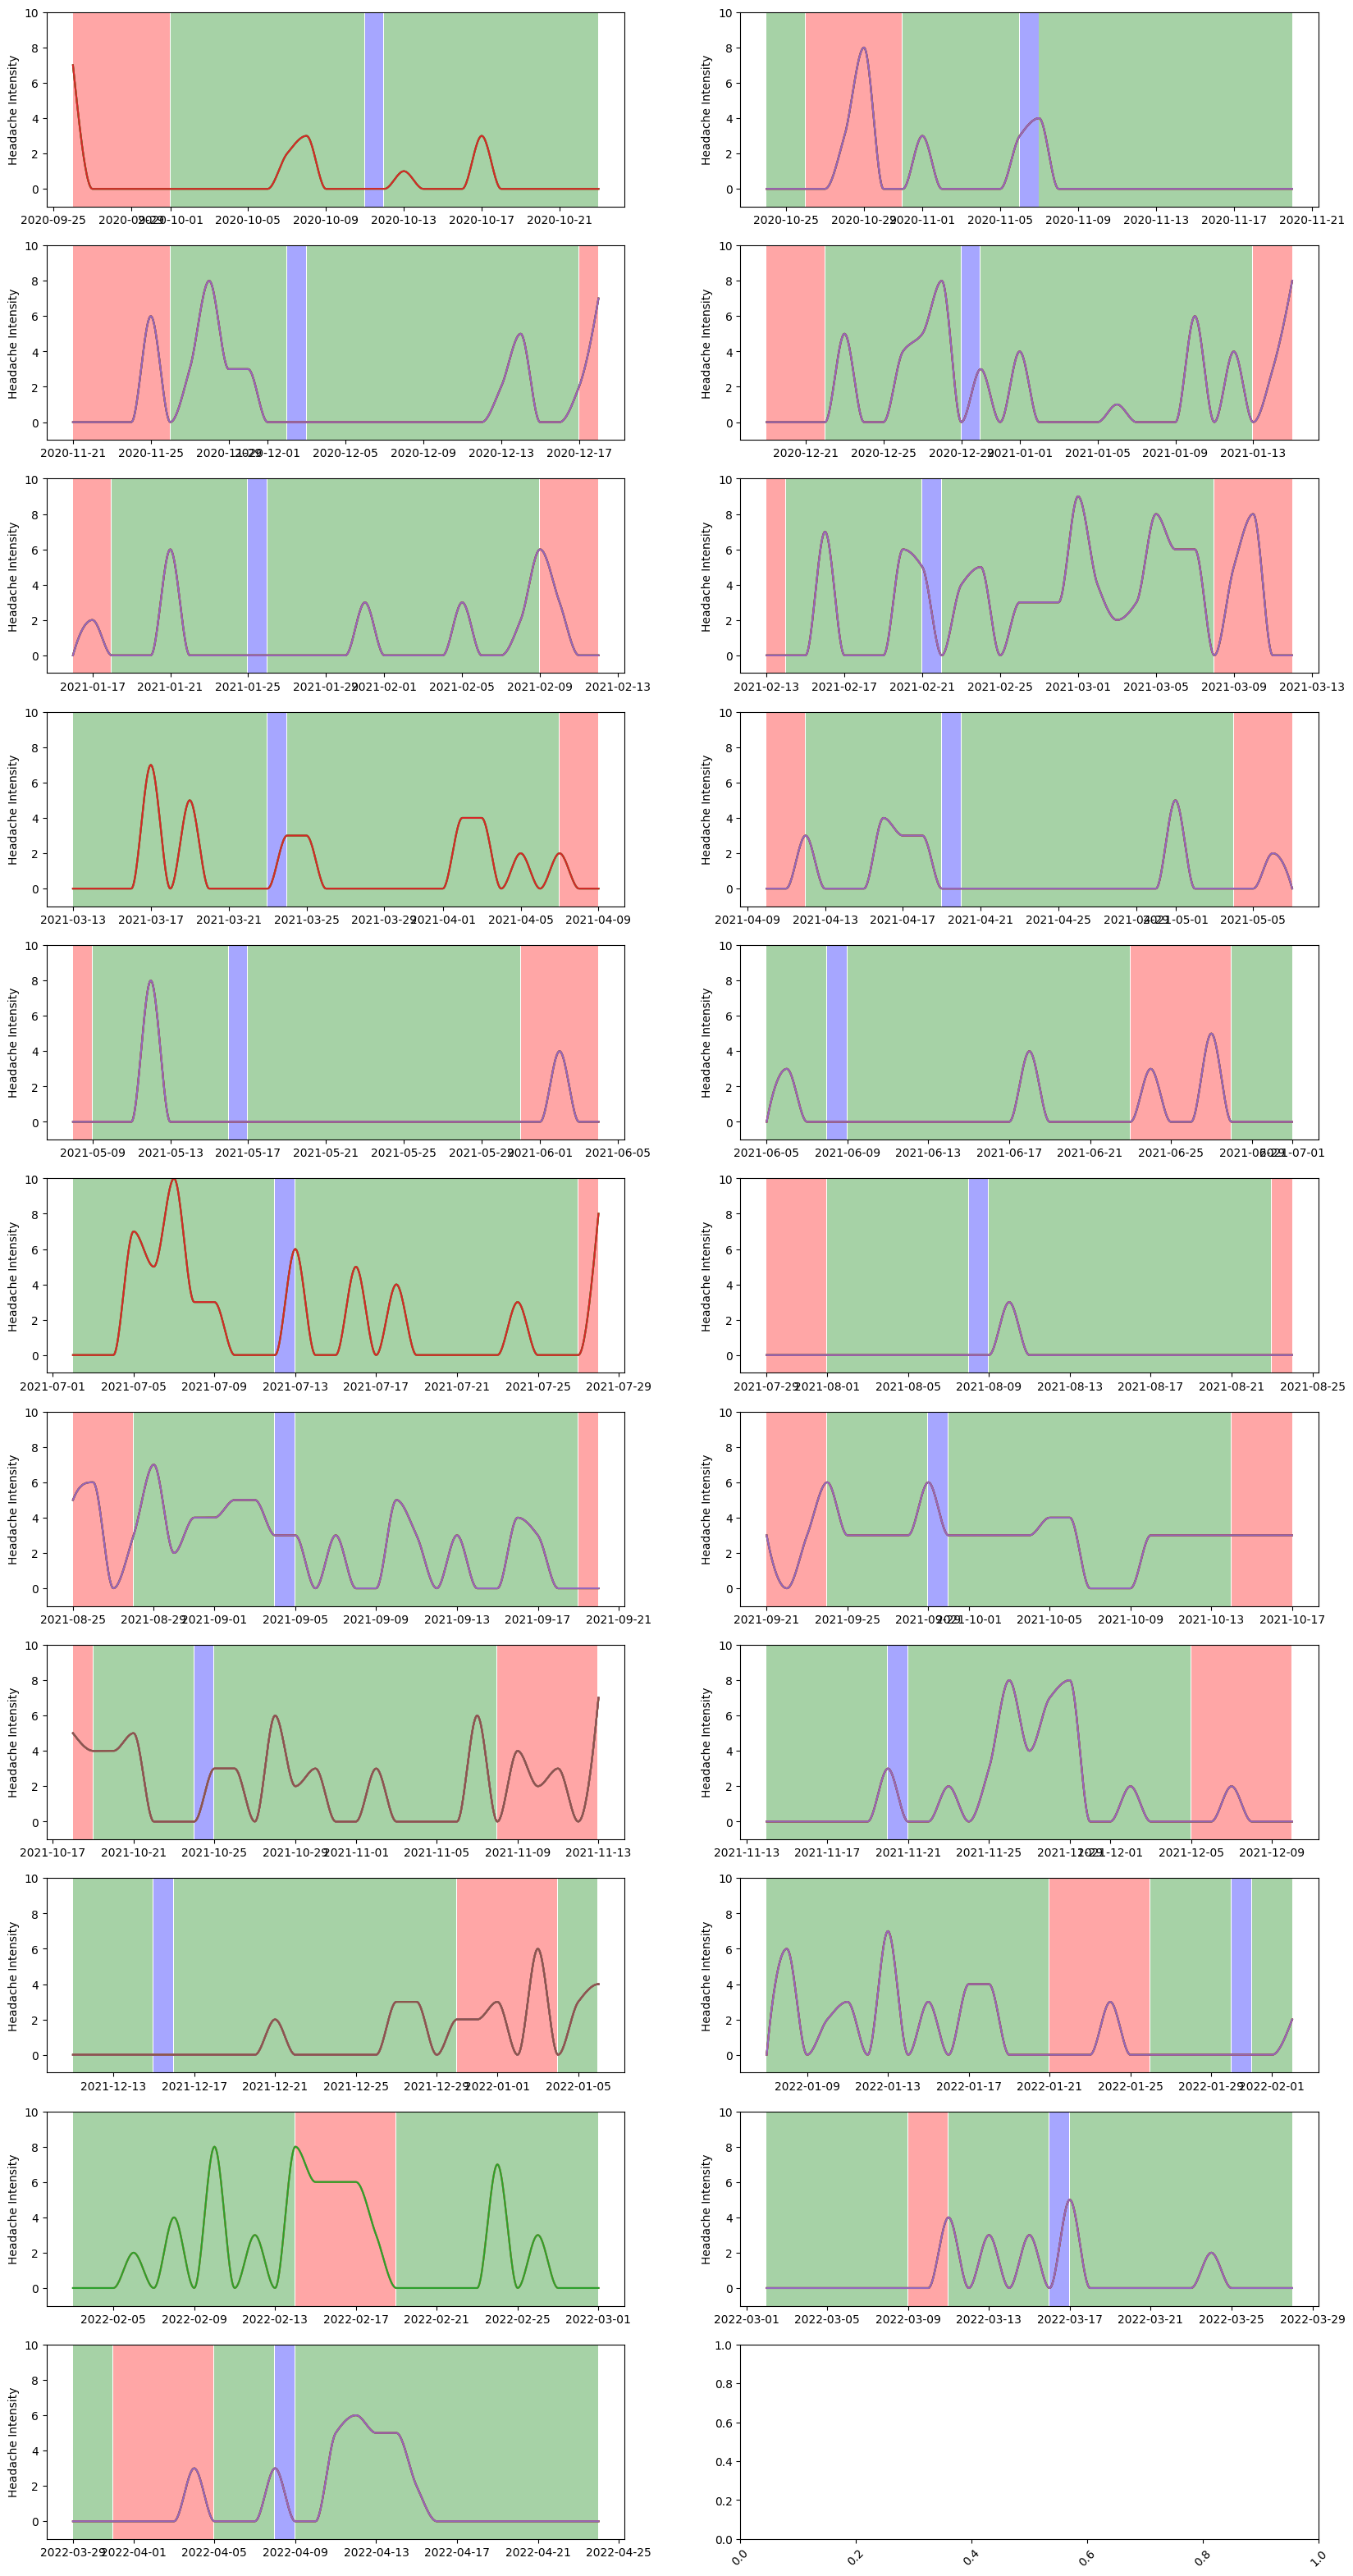

In [86]:
fig, axes = plt.subplots(nrows = 10, ncols =2)
fig.set_size_inches(20,40)
row_coord = 0
col_coord = 0
ind = 0

for df in split_dfs:
    df_hourly, index_hourly = migraine_hourly(df)
    y_dates, o_dates = period_lists(df)
    df_hourly = period_hourly(df_hourly, y_dates, o_dates)
    labels, datespans = label_span(df_hourly)
    ax = axes[row_coord, col_coord]

    y = df_hourly['Headache Intensity']
    ax.set_ylim([-1, 10])
    plt.xticks(rotation=45)
    for label, span in zip(labels, datespans):
        if label=='y':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='red')
        if label=='n':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='green')
        if label=='o':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='blue')
        sns.lineplot(data=df_hourly, x=df_hourly.index, y=y, ax=ax)

    
    
    if ind % 2 == 0:
        col_coord = 1
    else:
        row_coord += 1
        col_coord=0
    ind += 1
    
